Importing libraries

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re

Importing data set

In [2]:
df = pd.read_csv("imdb_dataset.csv")


Quick dataset descriptions

In [3]:
print(df.shape)
print(df.describe())


(50000, 2)
                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000


We have 50,000 reviews and 49,582 are unique, which means some reviews are exactly the same so we have 418 duplicates and some of them are more frequent than other. 

In [15]:
print("Null values:\n", df.isnull().sum())
print("Duplicate entries:", df.duplicated().sum())

Null values:
 review            0
sentiment         0
word_count        0
length_bucket    82
dtype: int64
Duplicate entries: 418


Just showing the first 10 reviews

In [4]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


This is showing the first 10 positive and negative reviews respectively

In [5]:
good_reviews=df[df['sentiment']=='positive']['review']
bad_reviews=df[df['sentiment']=='negative']['review']
print("First 10 samples of good reviews\n".format(),good_reviews[:10])
print("First 10 samples of bad reviews\n".format(),bad_reviews[:10])

First 10 samples of good reviews
 0     One of the other reviewers has mentioned that ...
1     A wonderful little production. <br /><br />The...
2     I thought this was a wonderful way to spend ti...
4     Petter Mattei's "Love in the Time of Money" is...
5     Probably my all-time favorite movie, a story o...
6     I sure would like to see a resurrection of a u...
9     If you like original gut wrenching laughter yo...
14    This a fantastic movie of three prisoners who ...
16    Some films just simply should not be remade. T...
18    I remember this film,it was the first film i h...
Name: review, dtype: object
First 10 samples of bad reviews
 3     Basically there's a family where a little boy ...
7     This show was an amazing, fresh & innovative i...
8     Encouraged by the positive comments about this...
10    Phil the Alien is one of those quirky films wh...
11    I saw this movie when I was about 12 when it c...
12    So im not a big fan of Boll's work but then ag...
13    The

Histogram for the distribution of the reviews... 

We probably not gonna use this but just saving if we will add it to our "bilag"


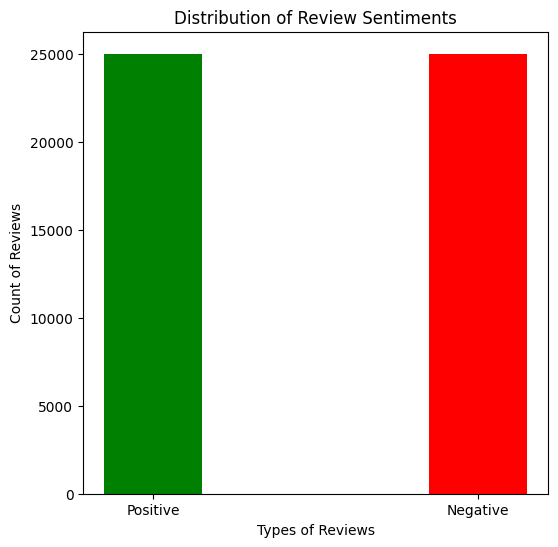

In [6]:
# Count positive and negative reviews
count_good = df[df['sentiment'] == 'positive']
count_bad = df[df['sentiment'] == 'negative']

# Plotting function
def plot_counts(count_good, count_bad):
    plt.rcParams['figure.figsize'] = (6, 6)
    plt.bar(0, count_good, width=0.6, label='Positive Reviews', color='green')
    plt.bar(2, count_bad, width=0.6, label='Negative Reviews', color='red')
    plt.ylabel('Count of Reviews')
    plt.xlabel('Types of Reviews')
    plt.xticks([0, 2], ['Positive', 'Negative'])
    plt.title('Distribution of Review Sentiments')
    plt.show()

# Call plot
plot_counts(len(count_good), len(count_bad))


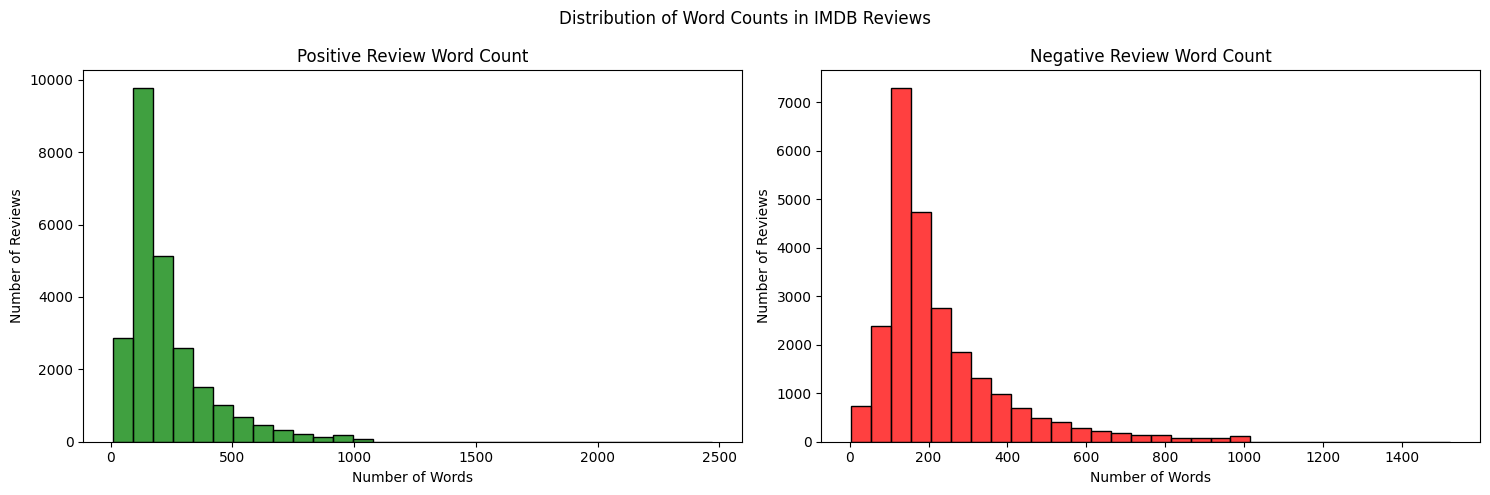

In [7]:
# Count words in each review
count_good_words = count_good['review'].str.split().apply(len)
count_bad_words = count_bad['review'].str.split().apply(len)

# Plot histograms
def plot_count(good_lengths, bad_lengths):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(good_lengths, ax=ax1, color='green', bins=30)
    ax1.set_title('Positive Review Word Count')
    ax1.set_xlabel('Number of Words')
    ax1.set_ylabel('Number of Reviews')

    sns.histplot(bad_lengths, ax=ax2, color='red', bins=30)
    ax2.set_title('Negative Review Word Count')
    ax2.set_xlabel('Number of Words')
    ax2.set_ylabel('Number of Reviews')

    fig.suptitle('Distribution of Word Counts in IMDB Reviews')
    plt.tight_layout()
    plt.show()

plot_count(count_good_words, count_bad_words)


made a graph with overlay 

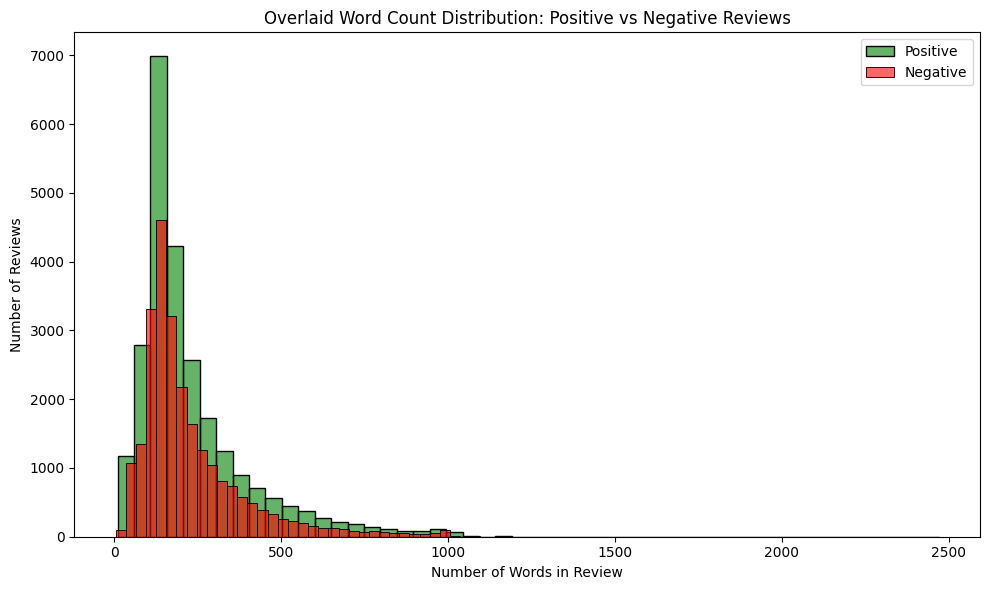

In [8]:
# Combined histogram
plt.figure(figsize=(10, 6))
sns.histplot(count_good_words, color='green', label='Positive', bins=50, kde=False, stat="count", alpha=0.6)
sns.histplot(count_bad_words, color='red', label='Negative', bins=50, kde=False, stat="count", alpha=0.6)

plt.title('Overlaid Word Count Distribution: Positive vs Negative Reviews')
plt.xlabel('Number of Words in Review')
plt.ylabel('Number of Reviews')
plt.legend()
plt.tight_layout()
plt.show()

here it's more clear that negative reviews are shorter and most are 100-200 words

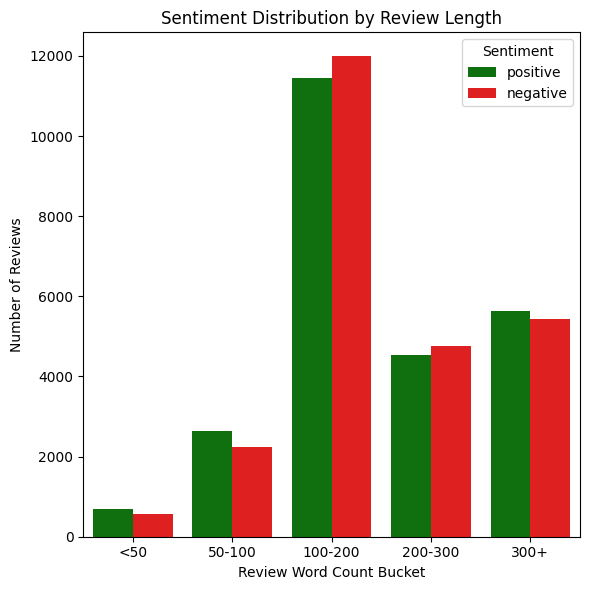

In [ ]:
df['word_count'] = df['review'].apply(lambda x: len(x.split()))
df['length_bucket'] = pd.cut(df['word_count'], bins=[0, 50, 100, 200, 300, 1000], labels=['<50', '50-100', '100-200', '200-300', '300+'])

sns.countplot(data=df, x='length_bucket', hue='sentiment', palette={'positive': 'green', 'negative': 'red'})
plt.title("Sentiment Distribution by Review Length")
plt.xlabel("Review Word Count Bucket")
plt.ylabel("Number of Reviews")
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

This just shows the same as the plot above but mmore comprehensible

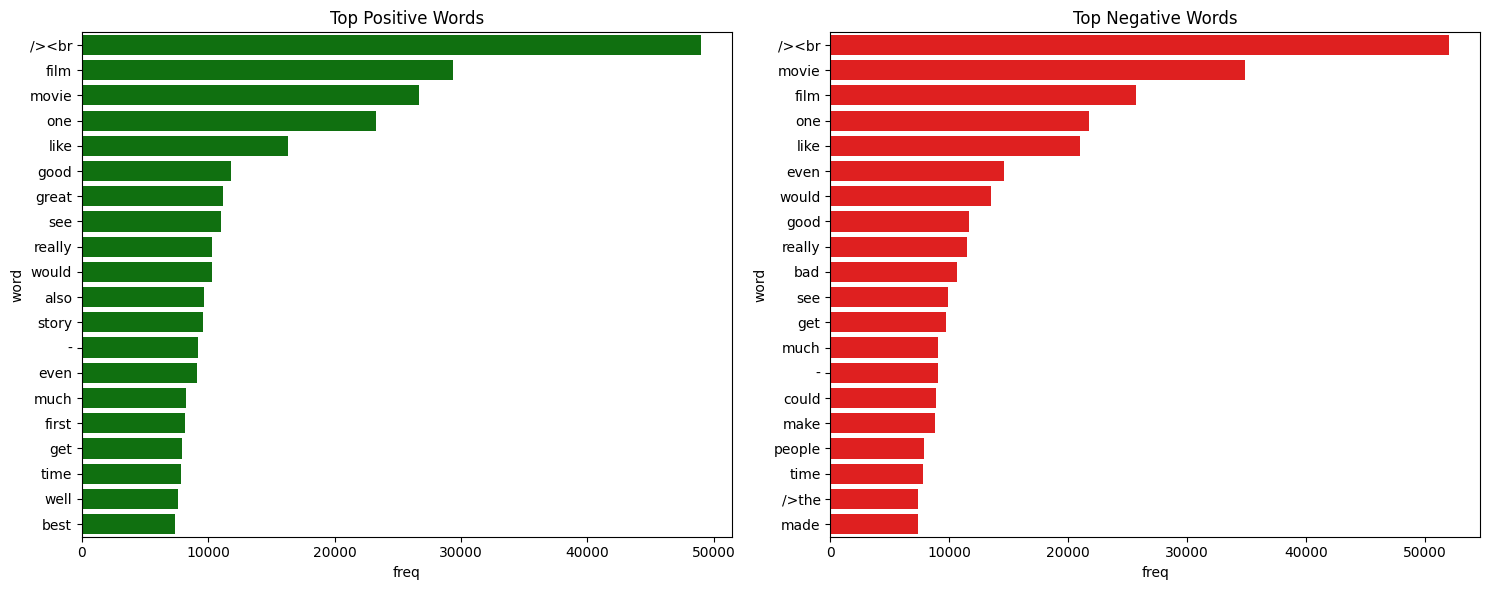

In [ ]:
#quiet for ignoring all the output
nltk.download('stopwords', quiet=True)

#prepare stopwords
stop_words = set(stopwords.words('english'))

#function to get top N words (excluding stopwords)
def get_top_n_words(corpus, n=None):
    vec = [word for review in corpus for word in review.lower().split() if word not in stop_words]
    word_freq = Counter(vec)
    return word_freq.most_common(n)

# Get top words for positive and negative reviews
top_pos = get_top_n_words(count_good['review'], 20)
top_neg = get_top_n_words(count_bad['review'], 20)

# Convert to DataFrame
top_pos_df = pd.DataFrame(top_pos, columns=['word', 'freq'])
top_neg_df = pd.DataFrame(top_neg, columns=['word', 'freq'])

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
sns.barplot(x='freq', y='word', data=top_pos_df, ax=axs[0], color='green')
axs[0].set_title("Top Positive Words")
sns.barplot(x='freq', y='word', data=top_neg_df, ax=axs[1], color='red')
axs[1].set_title("Top Negative Words")

plt.tight_layout()
plt.show()


This just shows that we need to clean the data before we start tokenising also see that there are more positive words in the positive reviews, where as the negative ones doesnt include that many negative loaded wordsd

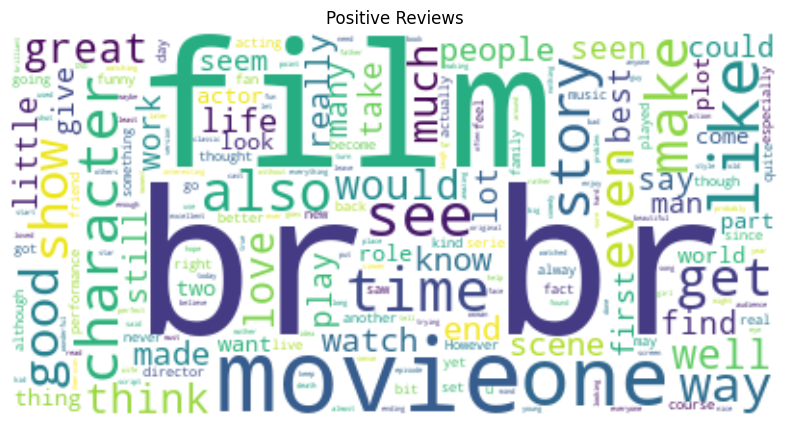

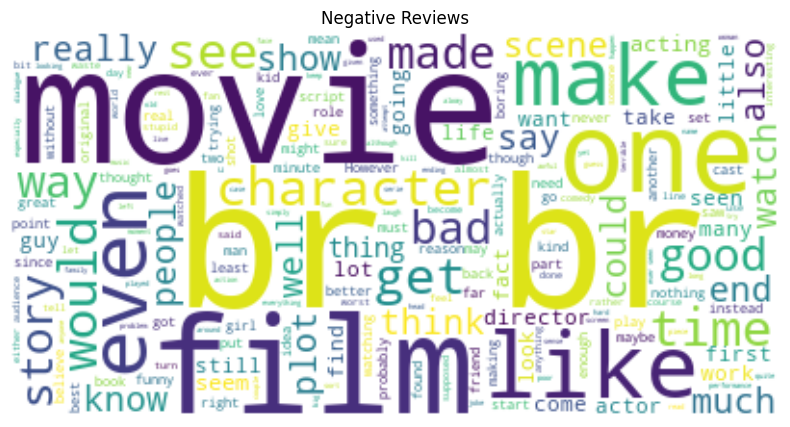

In [ ]:
def show_wordcloud(text, title = None):
    wordcloud = WordCloud(background_color='white', stopwords=stop_words, max_words=200).generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

show_wordcloud(good_reviews, "Positive Reviews")
show_wordcloud(bad_reviews, "Negative Reviews")


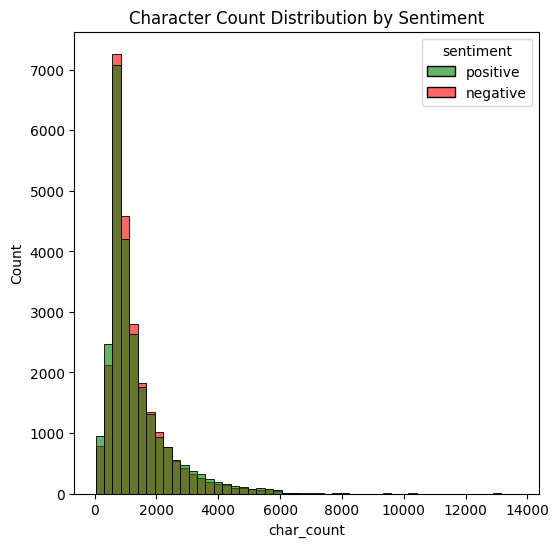

In [19]:
df['char_count'] = df['review'].apply(len)
sns.histplot(data=df, x='char_count', hue='sentiment', bins=50, palette={'positive': 'green', 'negative': 'red'}, alpha=0.6)
plt.title("Character Count Distribution by Sentiment")
plt.show()


In [22]:
sample_with_html = df[df['review'].str.contains(r'<[^>]+>')]
print(f"Reviews with HTML tags: {len(sample_with_html)}")


Reviews with HTML tags: 29202


In [21]:
very_short = df[df['word_count'] < 3]
print(f"Very short reviews (less than 3 words): {len(very_short)}")


Very short reviews (less than 3 words): 0
